In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import talib
from mpl_finance import candlestick2_ohlc, candlestick_ohlc
import matplotlib.dates as mdates
%matplotlib inline

In [2]:
codeList = ['A005930', 'A000660', 'A068270', 'A207940', 'A005380', 'A005490',\
            'A051910', 'A035420', 'A028260', 'A012330', 'A017670', 'A105560',\
            'A055550', 'A015760', 'A051900', 'A018260', 'A034730', 'A032830',\
            'A096770', 'A006400', 'A145020', 'A051370', 'A037460', 'A088800']
stName = ['삼성전자', 'SK하이닉스', '셀트리온', '삼성바이오로직스', '현대차', 'POSCO',\
          'LG화학', 'NAVER', '삼성물산', '현대모비스', 'SK텔레콤', 'KB금융', \
          '신한지주', '한국전력', 'LG생활건강', '삼성에스디에스', 'SK', '삼성생명',\
          'SK이노베이션', '삼성SDI', '휴젤', '인터플렉스', '삼지전자', '에이스테크']
Name2Code = {nm:code for nm, code in zip(stName, codeList)}
print(Name2Code)

{'삼성전자': 'A005930', 'SK하이닉스': 'A000660', '셀트리온': 'A068270', '삼성바이오로직스': 'A207940', '현대차': 'A005380', 'POSCO': 'A005490', 'LG화학': 'A051910', 'NAVER': 'A035420', '삼성물산': 'A028260', '현대모비스': 'A012330', 'SK텔레콤': 'A017670', 'KB금융': 'A105560', '신한지주': 'A055550', '한국전력': 'A015760', 'LG생활건강': 'A051900', '삼성에스디에스': 'A018260', 'SK': 'A034730', '삼성생명': 'A032830', 'SK이노베이션': 'A096770', '삼성SDI': 'A006400', '휴젤': 'A145020', '인터플렉스': 'A051370', '삼지전자': 'A037460', '에이스테크': 'A088800'}


In [9]:
close = pd.read_hdf('../StrategyExercise/week2. bullish vs bearish/daily_price_sample.h5', Name2Code["SK하이닉스"])
close.head(5)

date   open   high    low  close      vol     marketValue
date                                                                     
2016-08-22  20160822  35500  36050  35250  36000  4149396  26208072000000
2016-08-23  20160823  36250  36300  35550  35600  3014421  25916871000000
2016-08-24  20160824  35900  35950  35300  35750  1689924  26026071000000
2016-08-25  20160825  35100  35750  34900  35700  1568516  25989671000000
2016-08-26  20160826  35850  36350  35750  36250  2635343  26390072000000

In [10]:
def cal_momentum(close, lag=6):
    '''
    close : pd.Series
    '''
    moments = pd.Series(np.ones_like(close), index=close.index)
    for i in range(lag):
        moments *= (close.pct_change(i) + 1)
    return moments

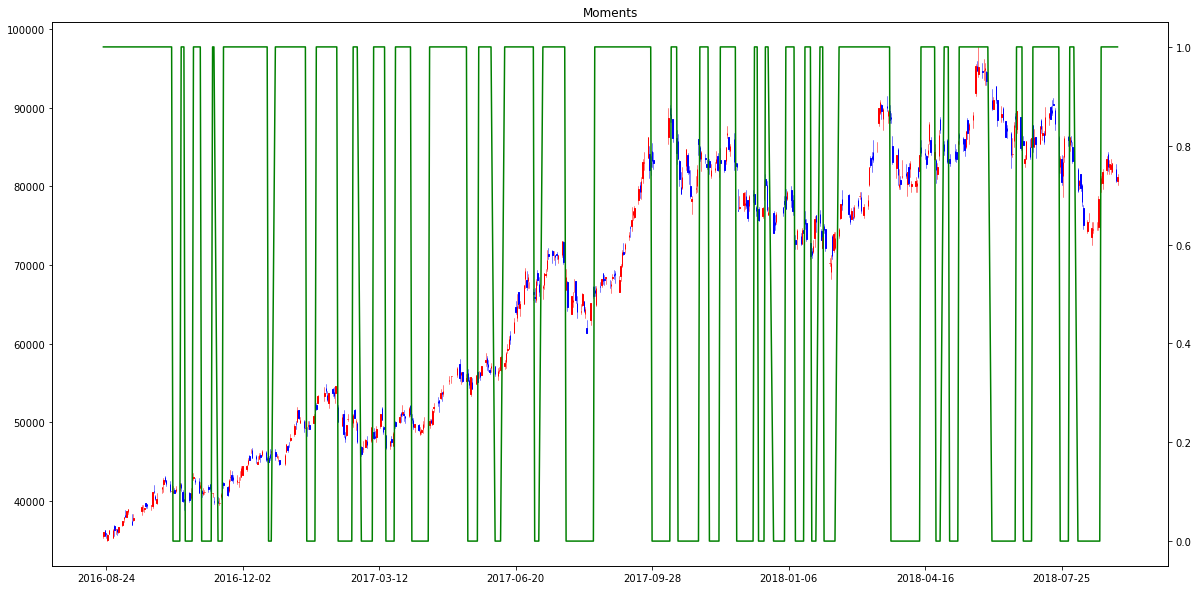

In [11]:
f1, ax = plt.subplots(1,1,figsize = (20,10))

close['date'] = close.index.map(mdates.date2num)
candlestick_ohlc(ax, close.loc[:, ['date', 'open','high','low','close']].values, colorup='red',colordown='blue', width=0.3)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Moments Index 구하기
moment = cal_momentum(close['close'])
moment[moment <= 1] = 0
moment[moment > 1] = 1
moment_idx = pd.Series(np.ones_like(moment), index=moment.index)
moment_ma = moment.rolling(5).mean().fillna(method='bfill')
moment_idx[moment_ma <= 0.5] = 0

ax1 = ax.twinx()
ax1.plot(moment.index, moment_idx, label = 'moment_idx', color='g')
ax1.set_title("Moments")

date
2018-08-29    False
2018-08-30     True
2018-08-31     True
2018-09-03     True
2018-09-04    False
dtype: bool
date
2018-08-29    1.000000
2018-08-30    0.992754
2018-08-31    0.989117
2018-09-03    0.990361
2018-09-04    1.000000
dtype: float64


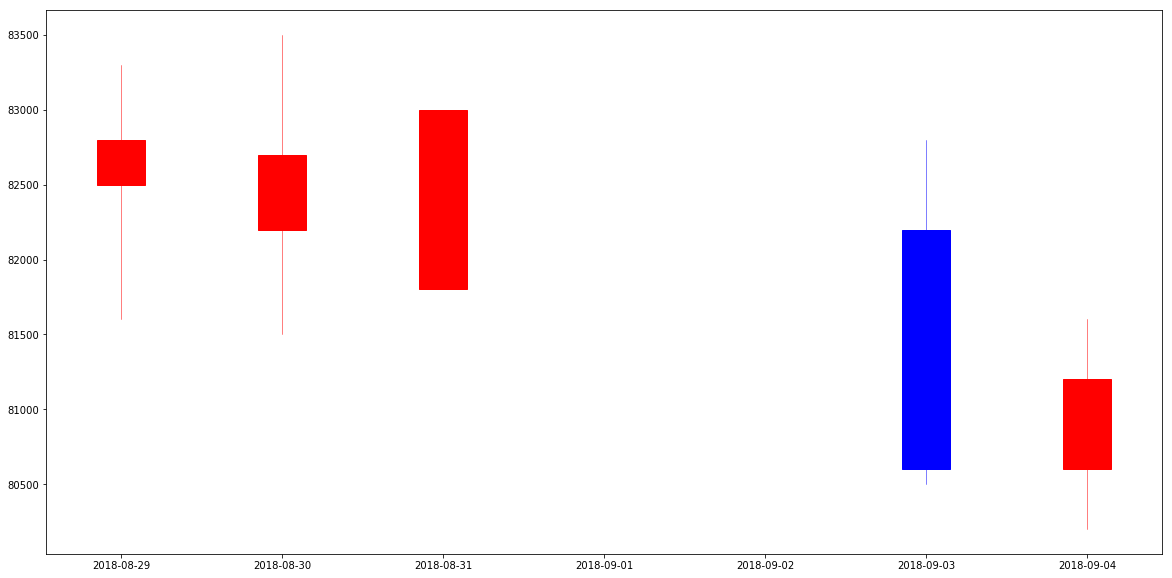

In [20]:
# 전일 양봉이고, momentum index가 특정값 이상일 경우만 선택
thd_trend = 0.0

b_positive = close['close'] > close['open']
b_trend = moment_idx >= thd_trend
b_cond = (b_positive & b_trend).shift(1).fillna(False)

profit = close['open'] / close['close'].shift(1)
profit[~b_cond] = 1.0

f1, ax = plt.subplots(1,1,figsize = (20,10))
candlestick_ohlc(ax, close.loc[:, ['date', 'open','high','low','close']].values[-5:], colorup='red',colordown='blue', width=0.3)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

print(b_cond.tail(5))
print(profit.tail(5))

Total Profit : 2.4191 / MDD : -0.0503


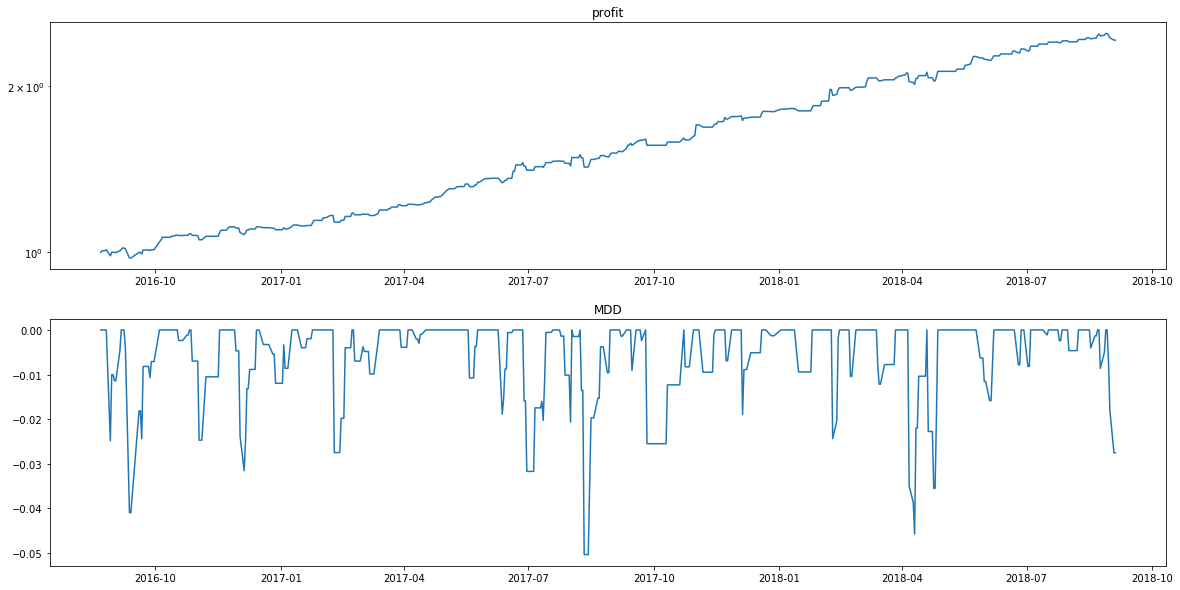

In [18]:
def plot_profit(profit_cumprod):
    # plot profit & MDD
    f1, (ax, ax1) = plt.subplots(2,1,figsize = (20,10))
    ax.set_title("profit")
    ax.semilogy(profit_cumprod)

    mdd = (profit_cumprod - profit_cumprod.cummax()) / profit_cumprod.cummax()
    ax1.set_title("MDD")
    ax1.plot(mdd)
    print("Total Profit : {0:0.4f} / MDD : {1:0.4f}".format(profit_cumprod.iloc[-1], mdd.min()))
    
plot_profit(profit.cumprod())

open2close - mean : 1.0011 / std : 0.0103
high2close - mean : 1.0157 / std : 0.0216
low2close  - mean : 0.9861 / std : 0.0163


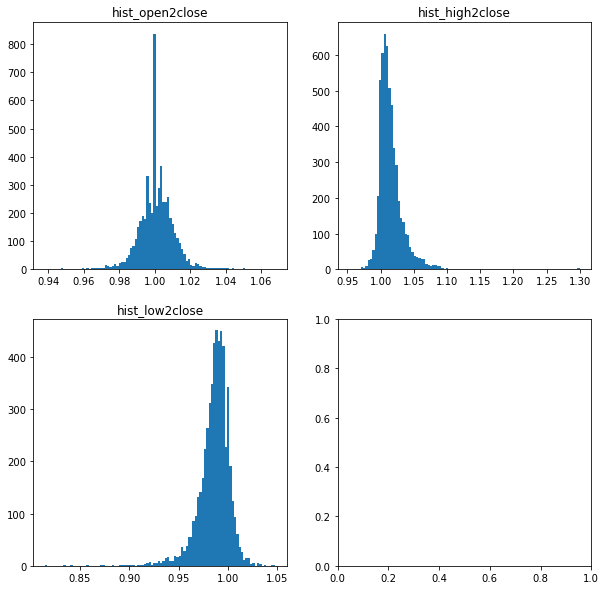

In [7]:
profit_total_oc = np.array([])
profit_total_hc = np.array([])
profit_total_lc = np.array([])

for nm, cd in Name2Code.items():
    close = pd.read_hdf('../StrategyExercise/week2. bullish vs bearish/daily_price_sample.h5', cd)
    
    b_positive = close['close'] > close['open']
    b_cond = b_positive.shift(1).fillna(False)

    profit_oc = close['open'] / close['close'].shift(1)
    profit_hc = close['high'] / close['close'].shift(1)
    profit_lc = close['low'] / close['close'].shift(1)
    profit_total_oc = np.append(profit_total_oc, profit_oc[b_cond].values)
    profit_total_hc = np.append(profit_total_hc, profit_hc[b_cond].values)
    profit_total_lc = np.append(profit_total_lc, profit_lc[b_cond].values)

fig, ([ax, ax1], [ax2, ax3]) = plt.subplots(2,2, figsize=(10,10))

ax.hist(profit_total_oc, bins=100)
ax.set_title("hist_open2close")
ax1.hist(profit_total_hc, bins=100)
ax1.set_title("hist_high2close")
ax2.hist(profit_total_lc, bins=100)
ax2.set_title("hist_low2close")

print("open2close - mean : {0:0.4f} / std : {1:0.4f}".format(np.mean(profit_total_oc), np.std(profit_total_oc)))
print("high2close - mean : {0:0.4f} / std : {1:0.4f}".format(np.mean(profit_total_hc), np.std(profit_total_hc)))
print("low2close  - mean : {0:0.4f} / std : {1:0.4f}".format(np.mean(profit_total_lc), np.std(profit_total_lc)))